In [126]:
from astropy.io import fits
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from HERA_calibration_sources import add_fluxes

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')



In [127]:
files = np.sort(glob('/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/*fits'))
HDUS = []
files = files
for f in files:
    HDUS.append(fits.open(f))

In [146]:
tb = add_fluxes(RA_range=('00:00:00','13:00:00'),dec_range=1, min_flux=4)
tb


Right ascension:
	Lower: 00h00m00s 
	Upper: 13h00m00s
Declination:
	Lower: -31.7214 degrees
	Upper: -29.7214 degrees
Minimum flux: 4 Jy
Number of regions found: 16

              Name of Center          RA        Dec  Total flux in region
0   TGSSADR J000355.1-305952    0.979820 -30.998020          11015.800091
1   TGSSADR J020012.1-305327   30.050440 -30.891060          25311.699249
2   TGSSADR J022720.2-303750   36.834339 -30.630619           9238.400185
3   TGSSADR J043300.3-295615   68.251488 -29.937559          10452.800014
4   TGSSADR J043832.8-311250   69.637009 -31.214149           7621.299988
5   TGSSADR J043736.5-295406   69.402321 -29.901720           9057.500076
6   TGSSADR J045826.4-300720   74.610413 -30.122379          19984.100246
7   TGSSADR J045514.2-300650   73.809464 -30.113991          23645.400387
8   TGSSADR J053115.5-303214   82.814827 -30.537470           8872.500113
9   TGSSADR J051330.6-303042   78.377602 -30.511909          18364.499821
10  TGSSADR J051342.

,Name of Center,RA,Dec,Total flux in region
0,TGSSADR J000355.1-305952,0.979820,-30.998020,11015.800091
1,TGSSADR J020012.1-305327,30.050440,-30.891060,25311.699249
2,TGSSADR J022720.2-303750,36.834339,-30.630619,9238.400185
3,TGSSADR J043300.3-295615,68.251488,-29.937559,10452.800014
4,TGSSADR J043832.8-311250,69.637009,-31.214149,7621.299988
5,TGSSADR J043736.5-295406,69.402321,-29.901720,9057.500076
6,TGSSADR J045826.4-300720,74.610413,-30.122379,19984.100246
7,TGSSADR J045514.2-300650,73.809464,-30.113991,23645.400387
8,TGSSADR J053115.5-303214,82.814827,-30.537470,8872.500113
9,TGSSADR J051330.6-303042,78.377602,-30.511909,18364.499821


In [147]:
plot_data = {v['Name of Center']: {'RA_diff': [], 'Flux': [], 'time': [],'Pixel_x': [],'Pixel_y': []} for _,v in tb.iterrows()}
source_info = {v['Name of Center']: {'RA': v['RA'], 'DEC': v['Dec'], 
                                     'Total_Flux': v['Total flux in region']} 
                                     for _,v in tb.iterrows()}

In [148]:
err = 3

f_count = len(files)
t = 0.0

c_prev = 0

for HDU,f in zip(HDUS,files):
    print ('Processing: ', f)
    # Read in file information
    fits_info = HDU[0].header
    ax1        = fits_info['NAXIS1']
    ax2        = fits_info['NAXIS2']
    units      = fits_info['BUNIT']
    c_ra       = fits_info['OBSRA']
    c_dec      = fits_info['OBSDEC']
    pix_size   = fits_info['CDELT2']
    c_pix1     = fits_info['CRPIX1']
    c_pix2     = fits_info['CRPIX2']
    
    data = HDU[0].data
    data = np.flip(data[0][0],axis=0)
    
    w = WCS(f)
    l_bound = w.all_pix2world(c_pix1,0,0,0,0)[0]
    r_bound = w.all_pix2world(c_pix1,ax2,0,0,0)[0]
    
    t += 1.0

    for _,src in tb.iterrows():
        # Convert a position to pixel values
        i,j = w.all_world2pix(src['RA'],src['Dec'],0,0,0)[:2]
        try:
            i = int(i)
            j = int(ax2-j)
        except:
            pass
        
        if (ax1-err > i > err) and (ax2-err > j > err):
            plot_data[src['Name of Center']]['Flux'].append(np.abs(data[j-err:j+err,i-err:i+err].max())/src['Total flux in region'])
            #plot_data[src['Name of Center']]['Flux'].append(np.abs(data[j-err:j+err,i-err:i+err].max()))
            ra_diff = c_ra-src['RA']
            
            # Correct for the difference in c_ra error
            if ra_diff > 30:
                ra_diff -= 360
            if ra_diff < -30:
                ra_diff += 360
                
            t = c_ra
                
            if c_ra-c_prev < -30:
                t = c_ra+360
            plot_data[src['Name of Center']]['RA_diff'].append(ra_diff)
            plot_data[src['Name of Center']]['time'].append(t)
            plot_data[src['Name of Center']]['Pixel_x'].append(j)
            plot_data[src['Name of Center']]['Pixel_y'].append(i)
    c_prev = c_ra

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28211.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28360.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28509.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28658.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28807.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.28956.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.36264.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.36413.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.36562.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.36711.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.36860.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.37009.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.44615.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.44764.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.44913.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.45062.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.45212.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.45361.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.52668.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.52817.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.52966.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.53116.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.53265.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.53414.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.60870.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.61019.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.61169.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.61318.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.61467.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.61616.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_

('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.68923.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.69073.uvOCRSL.uvfits.msFinal.combined.img.fits')
('Processing: ', '/home/tcox/data/HERA_data/2458042/HERA_imaging/IDR2-1_run_3.1/imgs/zen.grp1.of1.xx.LST.69222.uvOCRSL.uvfits.msFinal.combined.img.fits')


In [131]:
for k,v in plot_data.iteritems():
    print (len(v['Flux']))

77
78
77
77
77
53
77
77


In [132]:
cleaned_set = {k: v for k,v in plot_data.iteritems() if len(v['Flux']) >= 74 }
len(cleaned_set)

7

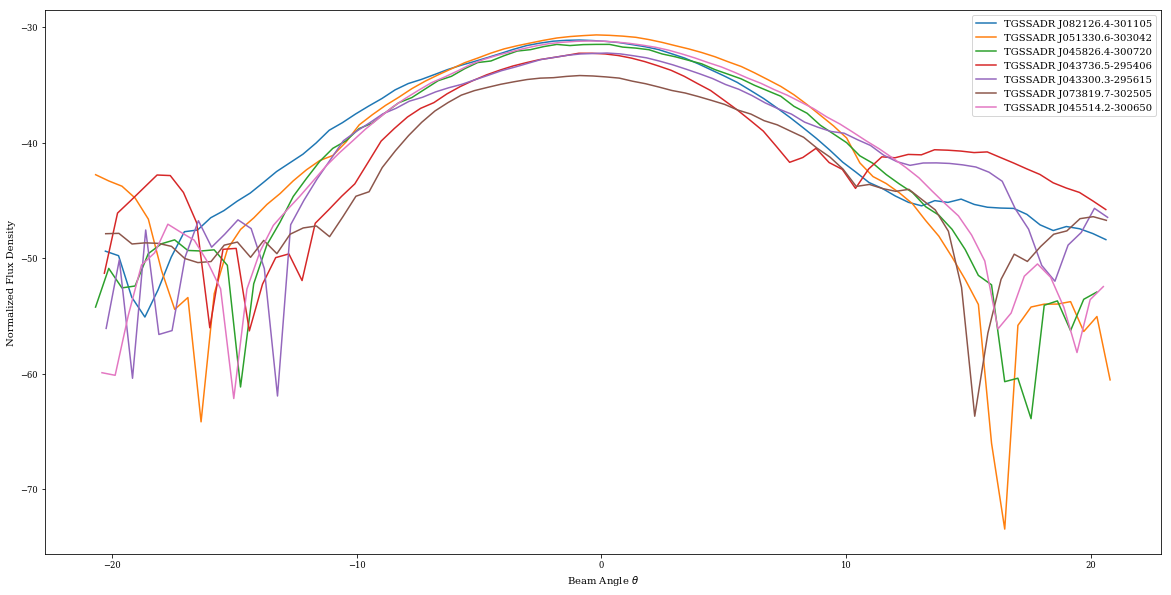

In [133]:
plt.figure(figsize=(20,10))

for key,item in cleaned_set.items():
    theta = item['RA_diff']
    flux = np.array(item['Flux'])
    plt.xlabel(r'Beam Angle $\theta$')
    plt.ylabel(r'Normalized Flux Density')
    #plt.title(key)
    plt.plot(theta,10*np.log10(flux),label=key)
plt.legend()
plt.show()

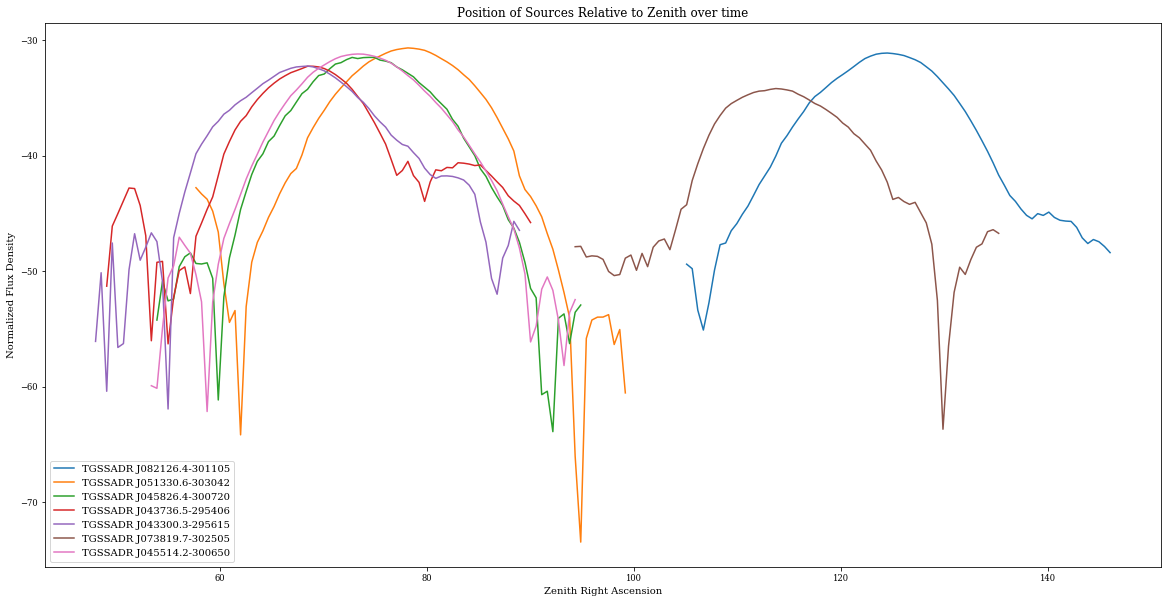

In [134]:
plt.figure(figsize=(20,10))

for key,item in cleaned_set.items():
    theta = item['time']
    flux = np.array(item['Flux'])
    plt.xlabel(r'Zenith Right Ascension')
    plt.ylabel('Normalized Flux Density')
    plt.plot(theta,10*np.log10(flux),label=key)
    
plt.title('Position of Sources Relative to Zenith over time')
plt.legend()
plt.show()

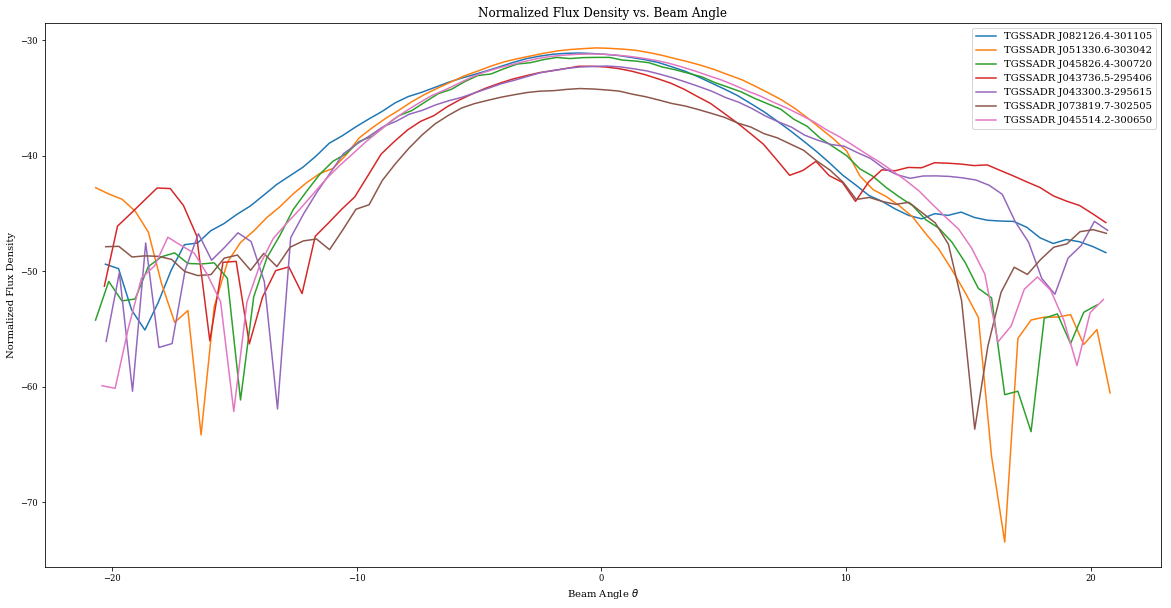

In [135]:
plt.figure(figsize=(20,10))

for key,item in cleaned_set.items():
    theta = item['RA_diff']
    flux = np.array(item['Flux'])
    plt.xlabel(r'Beam Angle $\theta$')
    plt.ylabel('Normalized Flux Density')
    plt.plot(theta,10*np.log10(flux),label=key)
    
plt.title('Normalized Flux Density vs. Beam Angle')
plt.legend()
plt.show()

In [136]:
for key,item in cleaned_set.items():
    print len(item['Flux'])

77
78
77
77
77
77
77


<Figure size 720x360 with 0 Axes>

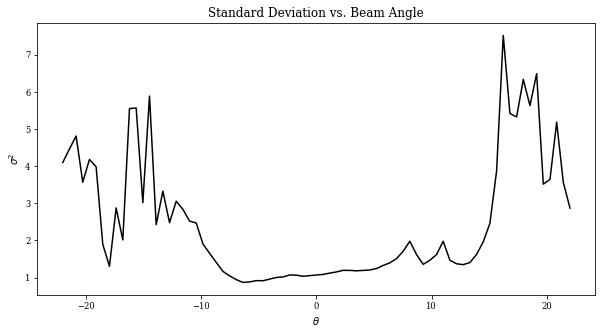

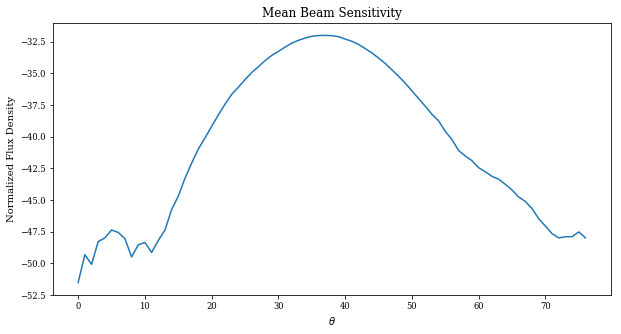

In [137]:
n = 77
l = np.zeros(n)
plt.figure(figsize=(10,5))

c = 0

for key,item in cleaned_set.items():
    theta = item['RA_diff']
    flux = np.array(item['Flux'])
    if len(flux) == n:
        l += flux
        c += 1

f = np.vstack([10*np.log10(item['Flux']) for key,item in cleaned_set.items() if len(item['Flux'])==n])

std = [np.std(f[:,i]) for i in range(f.shape[1])]

plt.figure(figsize=(10,5))

plt.plot(np.linspace(-22,22,len(std)),std,'k')
plt.title(r'Standard Deviation vs. Beam Angle')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\sigma^2$')
       

plt.figure(figsize=(10,5))

plt.xlabel(r'$\theta$')
plt.ylabel('Normalized Flux Density')
plt.title('Mean Beam Sensitivity')
plt.plot(range(l.size),10*np.log10(l/c))
plt.show()

In [138]:
import healpy as hp

In [139]:
filename = 'healpix_beam.fits'
beam_E = fits.getdata(filename, extname='BEAM_E')
nside = hp.npix2nside(beam_E.shape[0])
freqs = fits.getdata(filename, extname='FREQS')
freqs = freqs[50:150]
freqs

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199.])

In [140]:
# Loop over all frequencies
n = 30
m_theta = np.deg2rad(np.linspace(0,22,n))

normed_vals = np.array([])

for freq in freqs:
    ind = np.where(freqs == freq)[0][0]
    data = beam_E[:,ind]
    phi0 = np.deg2rad(0)
    vals0 = hp.ang2pix(nside,m_theta,phi0)
    plt0 = 10*np.log10(data[vals0])
    if normed_vals.shape[0] == 0:
        normed_vals = plt0
    else:
        normed_vals = np.vstack([normed_vals,plt0])

print normed_vals

m_theta = np.concatenate([-np.flip(m_theta,axis=0),m_theta])
normed_vals = np.hstack([np.flip(normed_vals,axis=1),normed_vals])

[[  6.09005517   6.05745377   6.00365181 ...  -6.01306655  -7.4585026
   -9.12885843]
 [  6.11017345   6.07507442   6.01520412 ...  -8.24878429 -10.36114045
  -13.07336575]
 [  6.18267376   6.14640189   6.08690045 ...  -7.50601142  -9.04569872
  -10.59457427]
 ...
 [ 24.98303561  24.81425604  24.53082821 ...  -4.64503182  -5.51942799
   -6.17938414]
 [ 24.99916709  24.82749923  24.54213298 ...  -4.67646479  -5.6387769
   -6.3656632 ]
 [ 25.0079214   24.83613887  24.54913386 ...  -4.42599851  -5.47452477
   -6.30074437]]


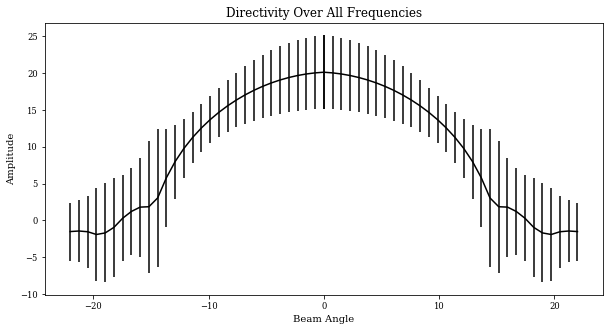

In [141]:
model_std = np.array([np.std(normed_vals[:,i]) for i in range(normed_vals.shape[1])])
model = np.array([np.mean(normed_vals[:,i]) for i in range(normed_vals.shape[1])])

plt.rc('font', family='serif')
plt.figure(figsize=(10,5))
plt.title('Directivity Over All Frequencies')
plt.xlabel('Beam Angle')
plt.ylabel('Amplitude')
plt.errorbar(np.rad2deg(m_theta),model,yerr=model_std,color='k',label=(r'$\alpha$ = ' + str(phi0)))
plt.show()

In [142]:
print normed_vals[0,:]

[-9.12885843 -7.4585026  -6.01306655 -4.74993172 -3.63418514 -2.63940958
 -1.74518201 -0.93699124 -0.20323732  0.46616528  1.0782474   1.63928361
  2.15408623  2.62636707  3.05980792  3.45754808  3.82023235  4.1519147
  4.45462799  4.7282456   4.97399473  5.19452636  5.38877594  5.55811611
  5.70462572  5.82660458  5.92639497  6.00365181  6.05745377  6.09005517
  6.09005517  6.05745377  6.00365181  5.92639497  5.82660458  5.70462572
  5.55811611  5.38877594  5.19452636  4.97399473  4.7282456   4.45462799
  4.1519147   3.82023235  3.45754808  3.05980792  2.62636707  2.15408623
  1.63928361  1.0782474   0.46616528 -0.20323732 -0.93699124 -1.74518201
 -2.63940958 -3.63418514 -4.74993172 -6.01306655 -7.4585026  -9.12885843]


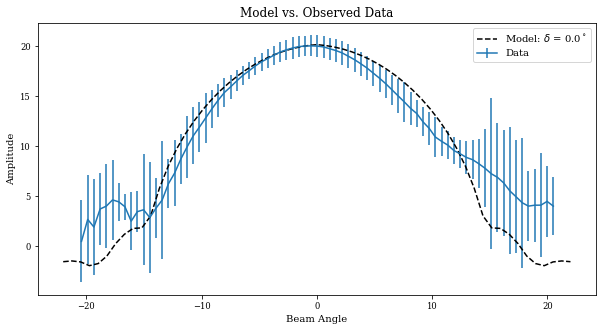

In [145]:
plt.rc('font', family='serif')
plt.figure(figsize=(10,5))
plt.title('Model vs. Observed Data')
plt.xlabel('Beam Angle')
plt.ylabel('Amplitude')

plt.plot(np.rad2deg(m_theta),model,'k--',label=(r'Model: $\delta$ = ' + str(phi0)) + r'$^\circ$')
plt.errorbar(theta,10*np.log10(l/c)+52,yerr=std,label='Data')
plt.legend()
plt.show()

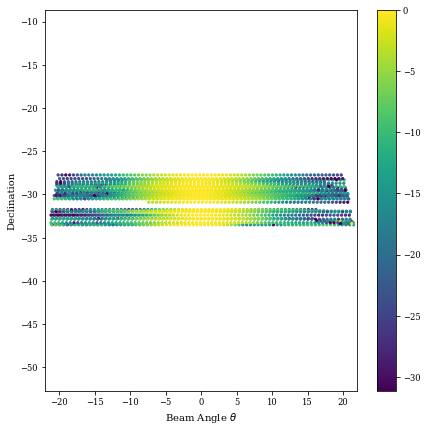

In [48]:
plt.figure(figsize=(7,7))
tot = np.array([])

for key,item in plot_data.items():
    theta = item['RA_diff']
    flux = np.array(item['Flux'])
    pix_x = np.array(item['Pixel_x'])
    pix_y = np.array(item['Pixel_y'])
    pix_x = source_info[key]['DEC']*np.ones(flux.shape[0])
    if pix_x.shape[0] != 0:
        scaled_flux = 10*np.log10(flux/flux.max())
        plt.scatter(theta,pix_x,c=scaled_flux,s=5)
        norm_flux = flux/flux.max()
        tot = np.hstack([tot,norm_flux])

plt.ylabel(r'Declination')
plt.xlabel(r'Beam Angle $\theta$')
plt.colorbar()
plt.xlim(-22,22)
plt.ylim(-22-30.7,-30.7+22)
plt.show()

The plot above is scaled incorrectly. When the colorbar was added it is scaled to the final source that is plotted. The next cell fixes this problem

In [49]:
import ECHO
import numpy as np

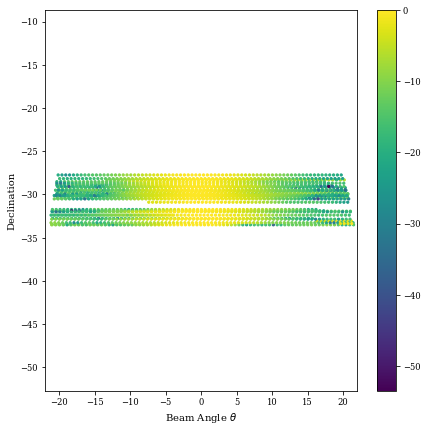

In [50]:
ang_ra = np.array([])
fluxes = np.array([])
ang_dec = np.array([])


for key,item in plot_data.items():
    theta = np.array(item['RA_diff'])
    flux = np.array(item['Flux'])
    pix_x = np.array(item['Pixel_x'])
    pix_y = np.array(item['Pixel_y'])
    pix_x = source_info[key]['DEC']*np.ones(flux.shape[0])
    if pix_x.shape[0] != 0:
        ang_ra = np.concatenate([ang_ra,theta])
        fluxes = np.concatenate([fluxes,flux/flux.max()])
        ang_dec = np.concatenate([ang_dec,pix_x])

plt.figure(figsize=(7,7))
plt.scatter(ang_ra,ang_dec,c=10*np.log10(fluxes),s=5)
plt.ylabel(r'Declination')
plt.xlabel(r'Beam Angle $\theta$')
plt.xlim(-22,22)
plt.ylim(-22-30.7,-30.7+22)
plt.colorbar()
plt.show()

In [59]:
grid, bins, rmsBins, _, xi, yi, gcounts, grms = ECHO.plot_utils.grid_data(ang_ra,ang_dec,10*np.log10(fluxes),binsize=0.5)

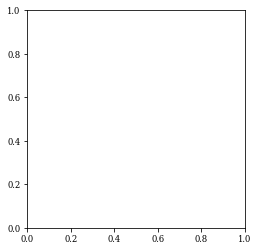

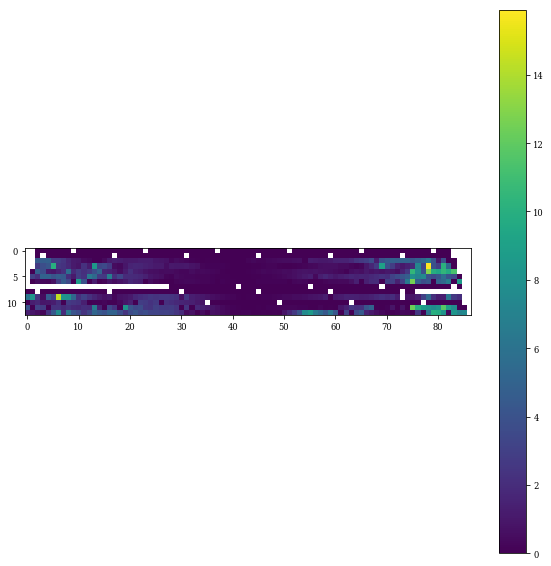

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(rmsBins,axis=0))
plt.colorbar()
plt.show()

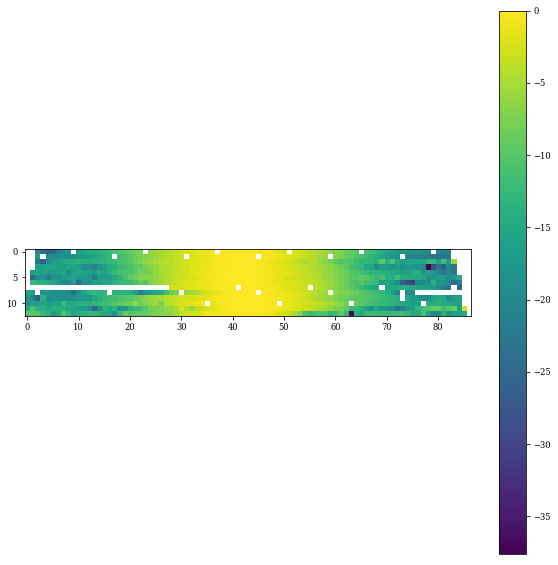

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(grid.data,axis=0))
plt.colorbar()
plt.show()

In [62]:
beam, rms, counts = ECHO.plot_utils.grid_to_healpix(xi,yi,alts=np.zeros_like(xi),rx=grid.data,lat0=-30,lon0=0,nside=32)

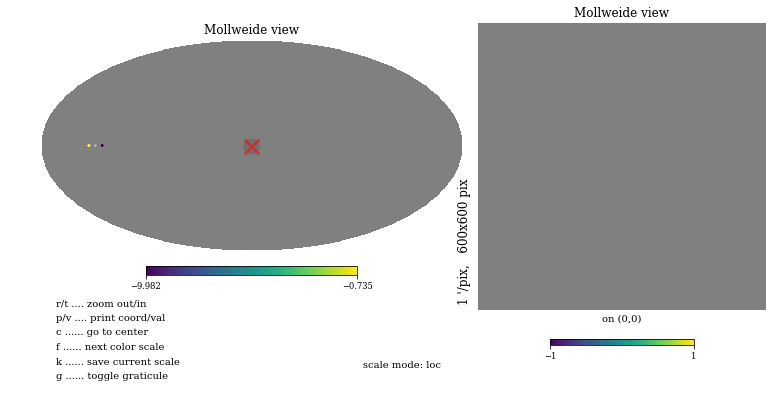

In [125]:
%matplotlib inline
hp.mollzoom(beam)

In [79]:
print np.std([0, 1], ddof=1)
print np.std([0, 1])

0.7071067811865476
0.5
